### Classification performance on engineered features with baseline models

This notebook is to experiment on various classification models (before moving onto neural networks) to distinguish pion and muon by using **engineered features** studied from the MDS team's regression baseline research. These engineered features have been explored to fit the ring_radius from a variable number of hits attached to each event.  

In the notebook, with a selected classifier, the performances of the classifier being trained globally (momentum from 15-45 GeV/c) and locally (each bin for 5 GeV/c) will be compared to verify the classification performances within different momentum range.

**IMPORTANT ASSUMPTIONS/CONDITIONS**:   
(1) The `label` column from the event dataset has been taken as the ground truth for the classification task in the notebook. 1 for muon; 0 for pion.   

(2) Data used in this notebook was generated from the full dataset then being filtered as below:  
Filter and keep the momentum range 15 - 45 GeV;   
Filter and keep hits with CHOD delta <= 0.5 ns (in-time hits only).     

(3) Any features produced from the SOTA (current NA62 algorithm) are not used in the classification task. 

In [1]:
import h5py 
import numpy as np 
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import glob
import warnings
import altair as alt

### 1.0 Read and prepare dataframes

In [2]:
# read events with hit features df (Tcut = 0.5 ns)
# only keep features for classification purpose
df = pd.read_parquet('project/data/events_with_hit_features_[cut_off_time=0.5].parquet'
                    )[['total_in_time_hits',
                       'x_aligned_min',
                       'x_aligned_max',
                       'x_aligned_width',
                       'y_aligned_min',
                       'y_aligned_max',
                       'y_aligned_width',
                       'hit_distance_min',
                       'hit_distance_max',
                       'hit_distance_mean',
                       'hit_distance_median',
                       'hit_distance_q25',
                       'hit_distance_q75',
                       'hit_distance_rms',
                       'hull_area',
                       'hull_diameter',
                       'hull_diff_width_diameter',
                       'hull_width',
                       'track_momentum',
                       'label'
                      ]]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2376174 entries, 0 to 2376173
Data columns (total 20 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   total_in_time_hits        uint32 
 1   x_aligned_min             float64
 2   x_aligned_max             float64
 3   x_aligned_width           float64
 4   y_aligned_min             float64
 5   y_aligned_max             float64
 6   y_aligned_width           float64
 7   hit_distance_min          float64
 8   hit_distance_max          float64
 9   hit_distance_mean         float64
 10  hit_distance_median       float64
 11  hit_distance_q25          float64
 12  hit_distance_q75          float64
 13  hit_distance_rms          float64
 14  hull_area                 float64
 15  hull_diameter             float64
 16  hull_diff_width_diameter  float64
 17  hull_width                float64
 18  track_momentum            float32
 19  label                     int32  
dtypes: float32(1), float64(1

In [4]:
# drop rows with track_momentum out of [15,45]
df = df.drop(df[df.track_momentum <15].index)
df = df.drop(df[df.track_momentum >45].index)

In [5]:
# count the number of particles (0 for muon; 1 for pion)
df['label'].value_counts()

0    1493811
1     194698
Name: label, dtype: int64

In [6]:
df.describe()

,total_in_time_hits,x_aligned_min,x_aligned_max,x_aligned_width,y_aligned_min,y_aligned_max,y_aligned_width,hit_distance_min,hit_distance_max,hit_distance_mean,hit_distance_median,hit_distance_q25,hit_distance_q75,hit_distance_rms,hull_area,hull_diameter,hull_diff_width_diameter,hull_width,track_momentum,label
count,1.688509e+06,1.688509e+06,1.688509e+06,1.688509e+06,1.688509e+06,1.688509e+06,1.688509e+06,1.688509e+06,1.688509e+06,1.688509e+06,1.688509e+06,1.688509e+06,1.688509e+06,1.688509e+06,1.688509e+06,1.688509e+06,1.688509e+06,1.688509e+06,1.688509e+06,1.688509e+06
mean,2.982868e+01,-2.164844e+02,1.754424e+02,3.919268e+02,-2.130279e+02,1.791699e+02,3.921977e+02,1.102708e+02,2.795723e+02,1.893073e+02,1.834456e+02,1.679609e+02,2.121290e+02,1.954272e+02,1.237029e+03,4.510073e+02,1.173096e+02,3.336976e+02,3.183104e+01,1.153076e-01
std,1.747927e+01,5.973234e+01,7.052641e+01,8.242953e+01,6.342503e+01,6.614275e+01,7.686638e+01,4.989293e+01,7.447334e+01,1.845638e+01,1.301127e+01,1.690277e+01,3.934439e+01,2.268296e+01,2.101007e+02,7.692867e+01,5.216877e+01,7.055424e+01,7.629166e+00,3.193929e-01
min,4.000000e+00,-5.084762e+02,-2.353556e+02,9.000000e+00,-5.038601e+02,-2.461987e+02,1.557999e+01,5.820465e-02,1.049481e+02,6.202501e+01,5.839689e+01,1.952811e+01,9.111714e+01,6.917790e+01,1.031644e+02,4.761900e+01,4.704039e-07,1.800198e+01,1.500004e+01,0.000000e+00
25%,1.700000e+01,-2.239120e+02,1.446776e+02,3.469000e+02,-2.222975e+02,1.532396e+02,3.482300e+02,6.691159e+01,2.167791e+02,1.792244e+02,1.786355e+02,1.612120e+02,1.884841e+02,1.818933e+02,1.096354e+03,3.922968e+02,7.679532e+01,2.891448e+02,2.613258e+01,0.000000e+00
50%,2.500000e+01,-2.033235e+02,1.741622e+02,3.870000e+02,-2.008626e+02,1.756379e+02,3.897100e+02,1.287938e+02,2.564738e+02,1.867037e+02,1.838449e+02,1.736529e+02,1.963767e+02,1.895519e+02,1.207380e+03,4.255778e+02,1.125434e+02,3.420164e+02,3.228308e+01,0.000000e+00
75%,3.800000e+01,-1.859275e+02,1.907383e+02,4.369000e+02,-1.800368e+02,1.908613e+02,4.417700e+02,1.512155e+02,3.372667e+02,1.966868e+02,1.877383e+02,1.794111e+02,2.233598e+02,2.057199e+02,1.393014e+03,5.143731e+02,1.515514e+02,3.810093e+02,3.801829e+01,0.000000e+00
max,2.930000e+02,2.160041e+02,4.906269e+02,6.439000e+02,2.051346e+02,4.691744e+02,6.026600e+02,2.908721e+02,5.466730e+02,3.592500e+02,4.251019e+02,3.444700e+02,4.884960e+02,3.804164e+02,1.932209e+03,6.677210e+02,4.868456e+02,5.783820e+02,4.499998e+01,1.000000e+00


In [7]:
# seperate data by momentum with range size = 5 Gev
df_15_20 = df.query('track_momentum >= 15 & track_momentum <= 20')
df_20_25 = df.query('track_momentum > 20 & track_momentum <= 25')
df_25_30 = df.query('track_momentum > 25 & track_momentum <= 30')
df_30_35 = df.query('track_momentum > 30 & track_momentum <= 35')
df_35_40 = df.query('track_momentum > 35 & track_momentum <= 40')
df_40_45 = df.query('track_momentum > 40 & track_momentum <= 45')

### 2.0 Perform training for basic model selection

This section is to perform training on various baseline models. To simplify the comparison, the models will be only trained globally (momentum from 15-45 GeV/c) with default parameters.

In [8]:
# import ML models and tools
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from helpers import mean_std_cross_val_scores
from helpers import train_test_split_range

#### 2.1 Prepare train/test df

In [9]:
# split to train and test dataframe
train_df, test_df = train_test_split(df,
                                     test_size=0.25,
                                     random_state=42,
                                     shuffle=True
                                    )

In [10]:
# check numbers of muon and pion in training df (0 for muon; 1 for pion)
train_df['label'].value_counts()

0    1120462
1     145919
Name: label, dtype: int64

In [11]:
# check numbers of muon and pion in testing df
test_df['label'].value_counts()

0    373349
1     48779
Name: label, dtype: int64

In [12]:
# generate X and y for training and test df
X_train, y_train = train_df.drop(columns=["label"]), train_df["label"]
X_test, y_test = test_df.drop(columns=["label"]), test_df["label"]

#### 2.2 Define pipelines and metrics

In [13]:
classification_metrics = ["accuracy", "precision", "recall", "f1"]

In [14]:
# define pipelines

preprocessor = StandardScaler()

pipe_dummy = make_pipeline(
    preprocessor, DummyClassifier())

pipe_lr = make_pipeline(
    preprocessor, LogisticRegression(max_iter=2000, 
                                     random_state=123,
                                     class_weight="balanced"))

pipe_dt = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=123,
                                                             class_weight="balanced"))

pipe_rf = make_pipeline(
    preprocessor, RandomForestClassifier(random_state=123, class_weight="balanced"))

pipe_xgb = make_pipeline(
    preprocessor, XGBClassifier(random_state=123, verbosity=0))

pipe_lgbm = make_pipeline(
    preprocessor, LGBMClassifier(random_state=123))

pipe_catboost = make_pipeline(
    preprocessor, CatBoostClassifier(verbose=0, random_state=123))

pipe_sklearn_histGB = make_pipeline(
    preprocessor, HistGradientBoostingClassifier(random_state=123))

pipe_sklearn_GB = make_pipeline(
    preprocessor, GradientBoostingClassifier(random_state=123))

classifiers = {
    "dummy classifier": pipe_dummy,
    "logistic regression": pipe_lr,
    "decision tree": pipe_dt,
    "random forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catboost,
    "sklearn_histGB": pipe_sklearn_histGB,
    "sklearn_GB": pipe_sklearn_GB,
}

In [15]:
warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

#### 2.3 Train models and obtain cross validation results

In [16]:
%%time
results = {}

for (name, model) in classifiers.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring=classification_metrics
    )

CPU times: user 2h 14min 2s, sys: 1min 44s, total: 2h 15min 46s
Wall time: 1h 32min 51s


In [17]:
pd.DataFrame(results).T

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
dummy classifier,0.195 (+/- 0.021),0.123 (+/- 0.004),0.885 (+/- 0.000),0.885 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)
logistic regression,2.210 (+/- 0.105),0.148 (+/- 0.004),0.734 (+/- 0.001),0.734 (+/- 0.000),0.261 (+/- 0.000),0.261 (+/- 0.000),0.713 (+/- 0.002),0.713 (+/- 0.001),0.382 (+/- 0.001),0.382 (+/- 0.000)
decision tree,28.367 (+/- 0.426),0.174 (+/- 0.006),0.907 (+/- 0.000),1.000 (+/- 0.000),0.596 (+/- 0.002),1.000 (+/- 0.000),0.587 (+/- 0.002),1.000 (+/- 0.000),0.591 (+/- 0.001),1.000 (+/- 0.000)
random forest,396.931 (+/- 2.091),4.126 (+/- 0.054),0.938 (+/- 0.000),1.000 (+/- 0.000),0.906 (+/- 0.002),1.000 (+/- 0.000),0.517 (+/- 0.002),1.000 (+/- 0.000),0.659 (+/- 0.002),1.000 (+/- 0.000)
XGBoost,43.940 (+/- 1.211),0.217 (+/- 0.004),0.943 (+/- 0.000),0.946 (+/- 0.000),0.858 (+/- 0.002),0.876 (+/- 0.001),0.607 (+/- 0.002),0.623 (+/- 0.001),0.711 (+/- 0.001),0.728 (+/- 0.001)
LightGBM,2.411 (+/- 0.295),0.430 (+/- 0.018),0.940 (+/- 0.000),0.941 (+/- 0.000),0.863 (+/- 0.003),0.868 (+/- 0.001),0.573 (+/- 0.002),0.577 (+/- 0.001),0.689 (+/- 0.002),0.693 (+/- 0.001)
CatBoost,46.354 (+/- 2.026),0.264 (+/- 0.014),0.946 (+/- 0.000),0.950 (+/- 0.000),0.862 (+/- 0.002),0.885 (+/- 0.000),0.629 (+/- 0.003),0.650 (+/- 0.001),0.727 (+/- 0.002),0.749 (+/- 0.000)
sklearn_histGB,5.183 (+/- 0.030),0.417 (+/- 0.005),0.940 (+/- 0.000),0.941 (+/- 0.000),0.864 (+/- 0.003),0.868 (+/- 0.001),0.573 (+/- 0.001),0.577 (+/- 0.001),0.689 (+/- 0.001),0.693 (+/- 0.000)
sklearn_GB,557.165 (+/- 3.256),0.428 (+/- 0.004),0.931 (+/- 0.000),0.931 (+/- 0.000),0.877 (+/- 0.003),0.879 (+/- 0.003),0.464 (+/- 0.002),0.466 (+/- 0.001),0.607 (+/- 0.002),0.610 (+/- 0.001)


#### 2.4 Performance of best model (CatBoostClassifier) on test data

In [18]:
pipe_catboost.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x13d549c00>)])

In [19]:
# prediction accuracy on test data
pipe_catboost.score(X_test, y_test)

0.9462864344464238

In [20]:
# prediction recall on test data
recall_score(y_test, pipe_catboost.predict(X_test))

0.634412349576662

In [21]:
# output predicted label vs given label (assuming as ground truth)
y_pred = pipe_catboost.predict(X_test)

pred_df = pd.DataFrame(y_pred, y_test).reset_index()
pred_df.columns=['given_label','predited_label']

In [22]:
pred_df

,given_label,predited_label
0,0,0
1,1,1
2,1,1
3,0,0
4,0,0
...,...,...
422123,0,0
422124,0,0
422125,1,0
422126,1,1


**Manually calculate pion efficiency on test data:**

In [23]:
# total number of true pion
num_pi_true = len(pred_df.query('given_label == 1'))
# Ture Positive (correctly predicted as pion)
num_pi_TP = len(pred_df.query('given_label == 1 & predited_label == 1'))

# recall(True Positive Rate)/pion efficiency
pi_efficiency = num_pi_TP/num_pi_true
pi_efficiency

0.634412349576662

**Manually calculate muon efficiency on test data:**

In [24]:
# total number of true muon
num_mu_true = len(pred_df.query('given_label == 0'))
# False Positive (incorrectly predicted as pion)
num_mu_FP = len(pred_df.query('given_label == 0 & predited_label == 1'))

# False Positive Rate/muon efficiency
mu_efficiency = num_mu_FP/num_mu_true
mu_efficiency

0.012966420159154035

**show confusion matrix**

[[368508   4841]
 [ 17833  30946]]


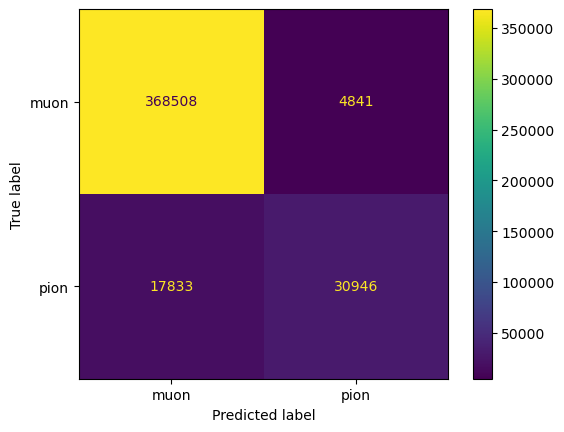

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = ConfusionMatrixDisplay.from_estimator(
    pipe_catboost, X_test, y_test, values_format="d", display_labels=["muon", "pion"]
)
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()
print(cm.confusion_matrix)

#### 2.5 ROC curves for three classifiers

For a quick comparison purpose, the ROC curve will be plotted for three classifiers from the above selection. 

In [26]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

In [27]:
# fit logisticregression on training data
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=2000,
                                    random_state=123))])

In [28]:
# fit randomforestclassifier on training data
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=123))])

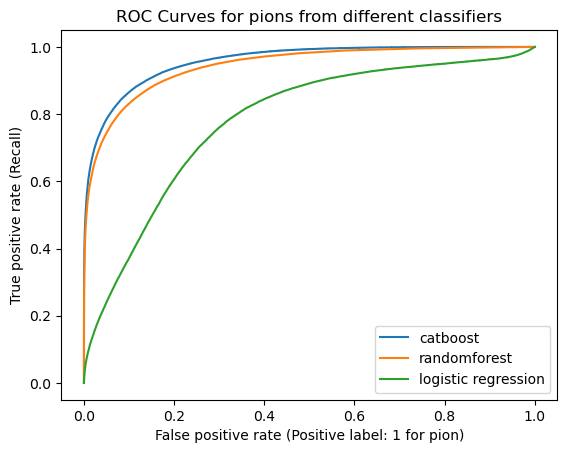

In [29]:
# plot ROC curves for three classifiers
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, pipe_lr.predict_proba(X_test)[:, 1])
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, pipe_rf.predict_proba(X_test)[:, 1])
fpr_cb, tpr_cb, thresholds_cb = roc_curve(y_test, pipe_catboost.predict_proba(X_test)[:, 1])

plt.plot(fpr_cb, tpr_cb, label="catboost")
plt.plot(fpr_rf, tpr_rf, label="randomforest")
plt.plot(fpr_lr, tpr_lr, label="logistic regression")

plt.xlabel("False positive rate (Positive label: 1 for pion)")
plt.ylabel("True positive rate (Recall)")
plt.legend(loc="best")
plt.title("ROC Curves for pions from different classifiers");

### 3.0 Compare classification performance with momentum bins

Based on the previous researches, the ring radius between pion and muon is too close in higher momentum range to make the classification more difficult. Therefore, we are exploring the classifier's performance on different momentum range in this section. Below we will use CatBoostClassifier to make the comparison.

Considering the unbalance observations between pion and muons, we will have two training approaches, unbalanced (by default) and balanced model setting.

#### 3.1 Unbalanced (by default) model

In [30]:
pipe_catboost_unbalanced = make_pipeline(
    preprocessor, CatBoostClassifier(verbose=0, random_state=123))

#### Train unbalanced model for each momentum bin

In [31]:
%%time
# train on global range for reference
results_unb = {}

X_train, y_train, X_test, y_test = train_test_split_range(df)
results_unb['momentum_15_45'] = mean_std_cross_val_scores(
    pipe_catboost_unbalanced, 
    X_train, 
    y_train, 
    return_train_score=True, 
    scoring=classification_metrics)

pipe_catboost_unbalanced.fit(X_train, y_train)
fpr_cb_15_45, tpr_cb_15_45, thresholds_cb_15_45 = roc_curve(y_test, 
                                                            pipe_catboost_unbalanced.predict_proba(X_test)[:, 1])

CPU times: user 28min 6s, sys: 49.2 s, total: 28min 55s
Wall time: 4min 34s


In [32]:
%%time

X_train, y_train, X_test, y_test = train_test_split_range(df_15_20)
results_unb['momentum_15_20'] = mean_std_cross_val_scores(
    pipe_catboost_unbalanced, 
    X_train, 
    y_train, 
    return_train_score=True, 
    scoring=classification_metrics)

pipe_catboost_unbalanced.fit(X_train, y_train)
fpr_cb_15_20, tpr_cb_15_20, thresholds_cb_15_20 = roc_curve(y_test, 
                                                            pipe_catboost_unbalanced.predict_proba(X_test)[:, 1])

CPU times: user 2min 39s, sys: 32.6 s, total: 3min 12s
Wall time: 38.1 s


In [33]:
X_train, y_train, X_test, y_test = train_test_split_range(df_20_25)
results_unb['momentum_20_25'] = mean_std_cross_val_scores(
    pipe_catboost_unbalanced, 
    X_train, 
    y_train, 
    return_train_score=True, 
    scoring=classification_metrics)

pipe_catboost_unbalanced.fit(X_train, y_train)
fpr_cb_20_25, tpr_cb_20_25, thresholds_cb_20_25 = roc_curve(y_test, 
                                                            pipe_catboost_unbalanced.predict_proba(X_test)[:, 1])

In [34]:
X_train, y_train, X_test, y_test = train_test_split_range(df_25_30)
results_unb['momentum_25_30'] = mean_std_cross_val_scores(
    pipe_catboost_unbalanced, 
    X_train, 
    y_train, 
    return_train_score=True, 
    scoring=classification_metrics)

pipe_catboost_unbalanced.fit(X_train, y_train)
fpr_cb_25_30, tpr_cb_25_30, thresholds_cb_25_30 = roc_curve(y_test, 
                                                            pipe_catboost_unbalanced.predict_proba(X_test)[:, 1])

In [35]:
X_train, y_train, X_test, y_test = train_test_split_range(df_30_35)
results_unb['momentum_30_35'] = mean_std_cross_val_scores(
    pipe_catboost_unbalanced, 
    X_train, 
    y_train, 
    return_train_score=True, 
    scoring=classification_metrics)

pipe_catboost_unbalanced.fit(X_train, y_train)
fpr_cb_30_35, tpr_cb_30_35, thresholds_cb_30_35 = roc_curve(y_test, 
                                                            pipe_catboost_unbalanced.predict_proba(X_test)[:, 1])

In [36]:
X_train, y_train, X_test, y_test = train_test_split_range(df_35_40)
results_unb['momentum_35_40'] = mean_std_cross_val_scores(
    pipe_catboost_unbalanced, 
    X_train, 
    y_train, 
    return_train_score=True, 
    scoring=classification_metrics)

pipe_catboost_unbalanced.fit(X_train, y_train)
fpr_cb_35_40, tpr_cb_35_40, thresholds_cb_35_40 = roc_curve(y_test, 
                                                            pipe_catboost_unbalanced.predict_proba(X_test)[:, 1])

In [37]:
X_train, y_train, X_test, y_test = train_test_split_range(df_40_45)
results_unb['momentum_40_45'] = mean_std_cross_val_scores(
    pipe_catboost_unbalanced, 
    X_train, 
    y_train, 
    return_train_score=True, 
    scoring=classification_metrics)

pipe_catboost_unbalanced.fit(X_train, y_train)
fpr_cb_40_45, tpr_cb_40_45, thresholds_cb_40_45 = roc_curve(y_test, 
                                                            pipe_catboost_unbalanced.predict_proba(X_test)[:, 1])

In [42]:
results_unb_df = pd.DataFrame(results_unb).T

In [43]:
results_unb_df = results_unb_df.reset_index()
results_unb_df.rename(columns = {'index':'momentum'}, inplace = True)
results_unb_df

,momentum,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,momentum_15_45,42.654 (+/- 1.129),0.237 (+/- 0.004),0.946 (+/- 0.000),0.950 (+/- 0.000),0.862 (+/- 0.002),0.885 (+/- 0.000),0.629 (+/- 0.003),0.650 (+/- 0.001),0.727 (+/- 0.002),0.749 (+/- 0.000)
1,momentum_15_20,6.101 (+/- 0.038),0.020 (+/- 0.001),0.984 (+/- 0.001),0.995 (+/- 0.000),0.955 (+/- 0.002),0.992 (+/- 0.001),0.892 (+/- 0.006),0.960 (+/- 0.002),0.923 (+/- 0.003),0.976 (+/- 0.001)
2,momentum_20_25,8.308 (+/- 0.011),0.033 (+/- 0.001),0.974 (+/- 0.000),0.985 (+/- 0.000),0.941 (+/- 0.004),0.975 (+/- 0.000),0.860 (+/- 0.006),0.912 (+/- 0.001),0.898 (+/- 0.002),0.943 (+/- 0.001)
3,momentum_25_30,11.164 (+/- 0.153),0.050 (+/- 0.001),0.960 (+/- 0.001),0.971 (+/- 0.000),0.897 (+/- 0.004),0.938 (+/- 0.001),0.783 (+/- 0.007),0.832 (+/- 0.001),0.836 (+/- 0.005),0.882 (+/- 0.001)
4,momentum_30_35,12.579 (+/- 0.059),0.059 (+/- 0.000),0.942 (+/- 0.000),0.953 (+/- 0.000),0.833 (+/- 0.005),0.889 (+/- 0.001),0.646 (+/- 0.006),0.700 (+/- 0.001),0.728 (+/- 0.003),0.783 (+/- 0.001)
5,momentum_35_40,12.046 (+/- 0.078),0.053 (+/- 0.001),0.925 (+/- 0.001),0.937 (+/- 0.000),0.760 (+/- 0.007),0.845 (+/- 0.002),0.439 (+/- 0.005),0.506 (+/- 0.001),0.557 (+/- 0.004),0.633 (+/- 0.001)
6,momentum_40_45,10.622 (+/- 0.054),0.044 (+/- 0.001),0.920 (+/- 0.001),0.933 (+/- 0.000),0.699 (+/- 0.021),0.849 (+/- 0.003),0.252 (+/- 0.005),0.335 (+/- 0.003),0.370 (+/- 0.008),0.480 (+/- 0.003)


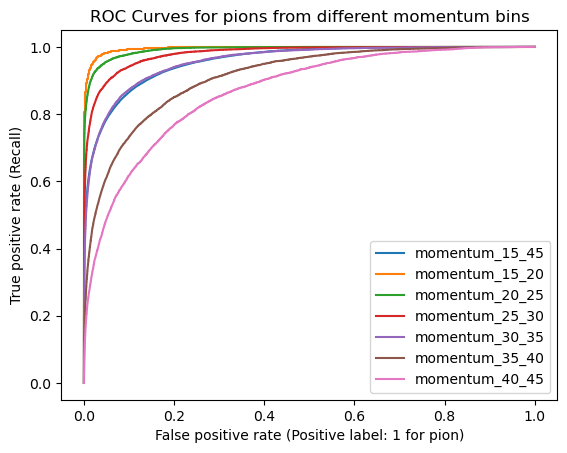

In [44]:
plt.plot(fpr_cb_15_45, tpr_cb_15_45, label="momentum_15_45")
plt.plot(fpr_cb_15_20, tpr_cb_15_20, label="momentum_15_20")
plt.plot(fpr_cb_20_25, tpr_cb_20_25, label="momentum_20_25")
plt.plot(fpr_cb_25_30, tpr_cb_25_30, label="momentum_25_30")
plt.plot(fpr_cb_30_35, tpr_cb_30_35, label="momentum_30_35")
plt.plot(fpr_cb_35_40, tpr_cb_35_40, label="momentum_35_40")
plt.plot(fpr_cb_40_45, tpr_cb_40_45, label="momentum_40_45")


plt.xlabel("False positive rate (Positive label: 1 for pion)")
plt.ylabel("True positive rate (Recall)")
plt.legend(loc="best")
plt.title("ROC Curves for pions from different momentum bins");

#### 3.2 Balanced model (to be updated)

In [45]:
# set scale_pos_weight to deal with class imbalance
# reference: https://www.kaggle.com/code/kaanboke/xgboost-lightgbm-catboost-imbalanced-data
pipe_catboost_balanced = make_pipeline(
    preprocessor, CatBoostClassifier(verbose=0, 
                                     random_state=123,
                                     scale_pos_weight=7)) # scale_pos_weight should be updated per ratio of positive cases